# Segmentation of Covid-19 lungs CT-Scan

__Importing the required libraries__

In [1]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from zipfile import ZipFile
from shutil import copyfile, copyfileobj
import gzip
from IPython.display import clear_output
import cv2
import os
from pylab import rcParams
import PIL   
from PIL import Image
import scipy
from google.colab import files
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift
import imgaug as ia
import imgaug.augmenters as iaa
import joblib
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.6.0
Eager mode:  True
GPU is available


In [2]:
import sys
import random
import warnings
import math
import seaborn as sns; sns.set()
from keras.callbacks import Callback
from keras.losses import binary_crossentropy
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
import gc

In [3]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [6]:
#!pip install git+https://github.com/qubvel/segmentation_models    # install segmentation model
import segmentation_models as sm        

Segmentation Models: using `tf.keras` framework.


In [7]:
!ls

sample_data


 __Here we are downloading datasets from kaggle__

In [8]:
!pip install kaggle

__Setting up kaggle and collab enviornment__

In [9]:
# taken username and key from JSON file
os.environ['KAGGLE_USERNAME'] = "vasantha3708"    
os.environ['KAGGLE_KEY'] = "464e8371c63dac74710b0a824fe48951"

In [10]:
!kaggle datasets download -d andrewmvd/covid19-ct-scans

 99% 1.02G/1.03G [00:09<00:00, 145MB/s]
100% 1.03G/1.03G [00:09<00:00, 115MB/s]


__Unzipping all the files__

In [11]:
with ZipFile('covid19-ct-scans.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('covid19-ct-scans')

In [12]:
pwd

'/content'

In [13]:
os.listdir('/content')

['.config', 'covid19-ct-scans.zip', 'covid19-ct-scans', 'sample_data']

# Reading the dataset

In [14]:
data = pd.read_csv('/content/covid19-ct-scans/metadata.csv')
data = data.replace('../input/covid19-ct-scans/','/content/covid19-ct-scans/',regex=True)
data.head(5)

ct_scan  ...                            lung_and_infection_mask
0  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
1  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
2  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
3  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
4  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...

[5 rows x 4 columns]

# Exploring the Dataset

In [15]:
ct_scan_path=[]
lung_mask_path=[]
infection_mask_path=[]
both_mask_path=[]
ct_scan_path=np.array(data['ct_scan'])
lung_mask_path=np.array(data['lung_mask'])
infection_mask_path=np.array(data['infection_mask'])
both_mask_path=np.array(data['lung_and_infection_mask'])
ct_scan_path[0]

'/content/covid19-ct-scans/ct_scans/coronacases_org_001.nii'

In [16]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    plt.grid(None) 

    plt.subplot(1,4,2)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Lung Mask')
    plt.grid(None)

    plt.subplot(1,4,3)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[2], alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')
    plt.grid(None)

    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[2], alpha=0.5, cmap=color_map)
    plt.title('Lung and Infection Mask')
    plt.grid(None)

    plt.show()

In [17]:
def enhanced_img(test_img,visualize):
    test_img = test_img*255
    test_img = np.uint8(test_img)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    clahe_image = clahe.apply(test_img)     # parameter passed must be of dtype uint8

    if(visualize==1):
        fig = plt.figure(figsize=(12,15))
        plt.subplot(1, 2, 1)
        plt.imshow(test_img, cmap='bone')
        plt.title("Original CT-Scan")
        plt.grid(None)
        plt.subplot(1,2,2)
        plt.imshow(clahe_image, cmap='bone')
        plt.title("Enhanced CT-Scan")
        plt.grid(None)
    
    return clahe_image

First Tried Manually cropping the image but it doesn't work out .
So, now cropping the image using contours.
From Lung mask Take contour along left lung and crop the img of left lung.
Then from the 2nd Lung, take contour along the second Lung and crop it.
Finally combine the both Cropped images to get the final croppped img.
Now store the contours points because to Crop the Ctscan and mask corresponding to each Ctscan.

In [18]:
def cropped_img(test_img,visualize):
    test_img=test_img*255
    test_img=np.uint8(test_img)
    contours,hierarchy = cv2.findContours(test_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    lung1_pt=[]
    lung2_pt=[]
    # left lung
    cnt1=contours[0]  
    x,y,w,z=cv2.boundingRect(cnt1)
    crp_1=test_img[y:y+z,x:x+w]
    crp_1 = cv2.resize(crp_1, dsize=(125,250), interpolation=cv2.INTER_AREA)     
    lung1_pt.append(x);lung1_pt.append(y);lung1_pt.append(w);lung1_pt.append(z);
    crp_2=crp_1
    #Right lung
    if(len(contours)==2):
        cnt2=contours[1]
        p,q,r,s=cv2.boundingRect(cnt2)
        crp_2=test_img[q:q+s,p:p+r]
        crp_2 = cv2.resize(crp_2, dsize=(125,250), interpolation=cv2.INTER_AREA)
        lung2_pt.append(p);lung2_pt.append(q);lung2_pt.append(r);lung2_pt.append(s);
    else:
        lung2_pt.append(x);lung2_pt.append(y);lung2_pt.append(w);lung2_pt.append(z);
        # before merging two image dimensions of 2 image must be same
    ROI = np.concatenate((crp_1, crp_2), axis=1)  
    if(visualize==1):
        fig = plt.figure(figsize=(10,8))
        plt.subplot(1,3,1)
        plt.imshow(crp_1)
        plt.grid(None)
        plt.subplot(1,3,2)
        plt.imshow(crp_2)
        plt.grid(None)
        plt.subplot(1,3,3)
        plt.imshow(ROI)
        plt.grid(None)
        plt.show()
    return (ROI,lung1_pt,lung2_pt)

In [19]:
points_1=[]
points_2=[]
img_size=512

In [20]:
def read_nii_demo(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    slices = array.shape[2]

    return array

In [21]:
def read_nii(filepath,img_arr,string):

    global points_1
    global points_2
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    slices = array.shape[2]
    # get the slices b/w 25% and 75%
    array = array[:,:,round(slices*0.25):round(slices*0.75)]
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1],1))
    
    if string=='lungs':
      points_1=[]
      points_2=[]

    for img_no in range(0, array.shape[0]):
      #To remove the blurry images
      if string=='lungs' and np.unique(array[img_no]).size == 1:
        continue
      img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)  #resizing all images to the same dimensions
      # Normalising the Image
      xmax, xmin = img.max(), img.min()
      img = (img - xmin)/(xmax - xmin)
      
      if string == 'lungs':
          # img = np.uint8(img*255) 
          img[img>0]=1
          img, pts1, pts2 = cropped_img(img, visualize= 0)
          points_1.append((pts1[0], pts1[1], pts1[2], pts1[3]))
          points_2.append((pts2[0], pts2[1], pts2[2], pts2[3]))
          continue 

      if string == "cts" and img_no < len(points_1):
          img = enhanced_img(img, visualize= 0)
          a,b,c,d = points_1[img_no]
          e,f,g,h = points_2[img_no]
          img1 = img[b:b+d, a:a+c]
          img1 = cv2.resize(img1, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img2 = img[f:f+h, e:e+g]
          img2 = cv2.resize(img2, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img = np.concatenate((img1, img2), axis=1)    

      if string == "infections" and img_no < len(points_2):
          a,b,c,d = points_1[img_no]
          e,f,g,h = points_2[img_no]
          img = np.uint8(img*255)
          img1 = img[b:b+d, a:a+c]
          img1 = cv2.resize(img1, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img2 = img[f:f+h, e:e+g]
          img2 = cv2.resize(img2, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img = np.concatenate((img1, img2), axis=1)

        
      img_arr.append(img)

In [22]:
index=1
sample_ct=read_nii_demo(ct_scan_path[index])
sample_lung=read_nii_demo(lung_mask_path[index])
sample_infe=read_nii_demo(infection_mask_path[index])
sample_all=read_nii_demo(both_mask_path[index])

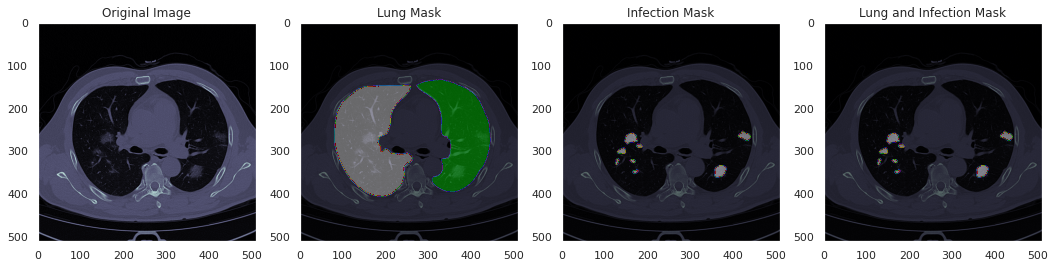

In [23]:
plot_sample([sample_ct[...,120], sample_lung[...,120], sample_infe[...,120], sample_all[...,120]])

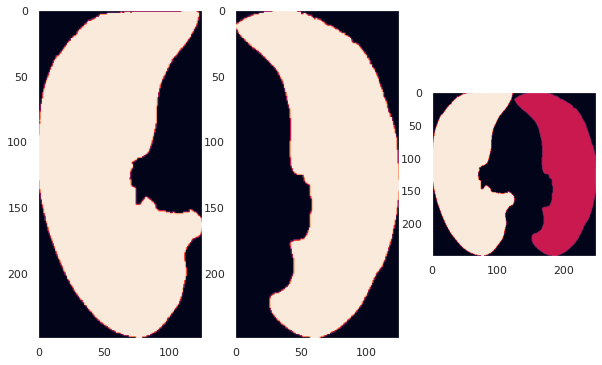

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 [81, 147, 182, 261],
 [273, 135, 172, 262])

In [24]:
# normalising the sample CT_Scan and sample lung 
sample_ct=(sample_ct-sample_ct.min())/(sample_ct.max()-sample_ct.min())
sample_lung=(sample_lung-sample_lung.min())/(sample_lung.max()-sample_lung.min())
cropped_img(sample_lung[...,120],visualize=1)

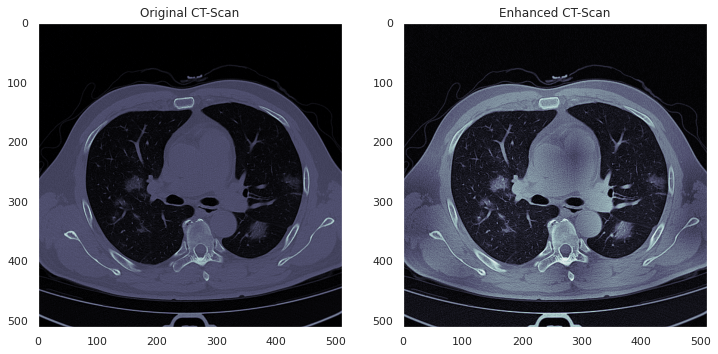

In [25]:
#sample_ct_grey=cv2.cvtColor(sample_ct[...,120],cv2.COLOR_BGR2GRAY)
img=enhanced_img(sample_ct[...,120],visualize=1)

In [26]:
cts = []
lungs = []
infections = []

In [27]:
for i in range(0, 20):
  read_nii(data.loc[i,'lung_mask'], lungs, 'lungs')
  read_nii(data.loc[i,'ct_scan'], cts, 'cts') 
  read_nii(data.loc[i,'infection_mask'], infections, 'infections')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


(250, 250) (250, 250)


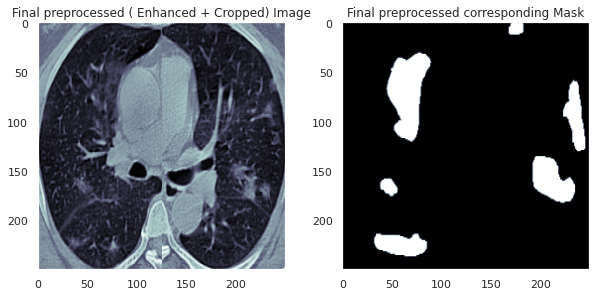

In [28]:
ind = 109
rcParams['figure.figsize'] = 10,10
plt.subplot(2, 2, 1)
plt.imshow(cts[ind], cmap='bone')
plt.title("Final preprocessed ( Enhanced + Cropped) Image")
plt.grid(None)
plt.subplot(2, 2, 2)
plt.imshow(infections[ind], cmap='bone')
plt.title("Final preprocessed corresponding Mask")
plt.grid(None)
print(cts[ind].shape, infections[ind].shape)

Some of them Masks are complete Black we remove those black Masks to pass the rest of the images from segmentation Model to Segment the infection.
In Segmentation model we have to only pass the masks which are not completely Black.

In [29]:
complete_black_masks = []
for i in range(0, len(infections)):
  if np.unique(infections[i]).size == 1:
    complete_black_masks.append(i)
print("Number of complete black masks :" , len(complete_black_masks))
for index in sorted(complete_black_masks, reverse = True):  
    del infections[index]  
    del cts[index]

Number of complete black masks : 374


In [30]:
 joblib.dump(cts, 'cts_cropped_lungs_250.pkl')

['cts_cropped_lungs_250.pkl']

In [31]:
files.download('cts_cropped_lungs_250.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
joblib.dump(infections, 'infections_cropped_lungs_250.pkl')

['infections_cropped_lungs_250.pkl']

In [33]:
files.download('infections_cropped_lungs_250.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
cts=joblib.load('/content/drive/My Drive/cts_cropped_lungs_250.pkl')
infections=joblib.load('/content/drive/My Drive/infections_cropped_lungs_250.pkl')

In [36]:
new_dim=128

In [37]:
# Resizing the images to the same dimensions
for i in range(0,len(cts)):
  cts[i] = cv2.resize(cts[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
  infections[i] = cv2.resize(infections[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)

In [38]:
cts = np.array(cts)
infections = np.array(infections)
cts = np.uint8(cts)
infections = np.uint8(infections)

In [39]:
def plot_processed_sample(array_list, color_map = 'nipy_spectral'):
    fig = plt.figure(figsize=(10,8))
    plt.subplot(1,2,1)
    plt.imshow(array_list[0].reshape(new_dim, new_dim), cmap='bone')
    plt.title('Original Image')
    plt.grid(None)
    plt.subplot(1,2,2)
    plt.imshow(array_list[0].reshape(new_dim, new_dim), cmap='bone')
    plt.imshow(array_list[1].reshape(new_dim, new_dim), alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')
    plt.grid(None)
    plt.show()

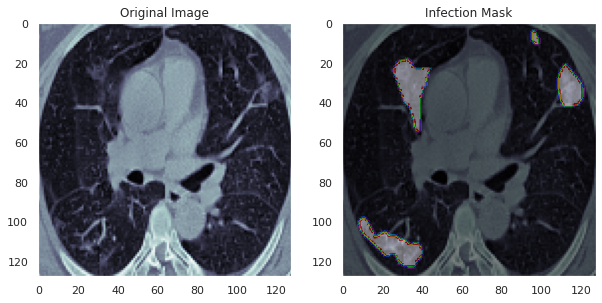

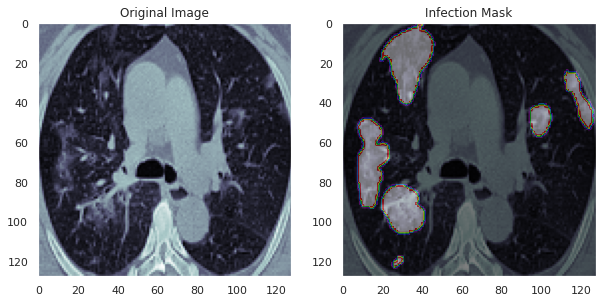

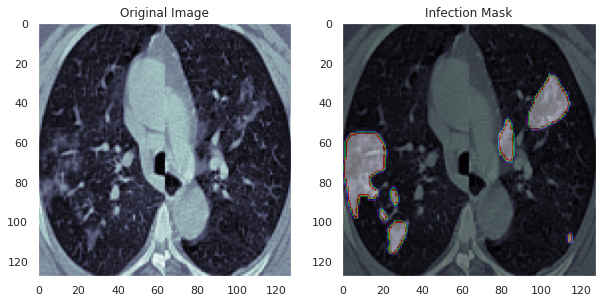

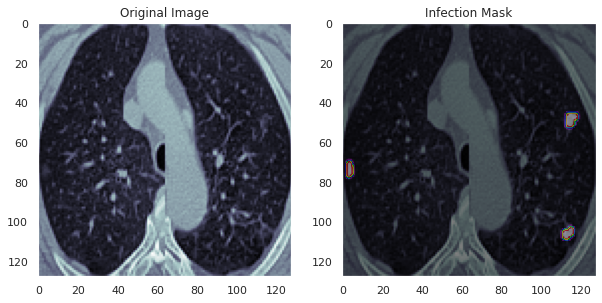

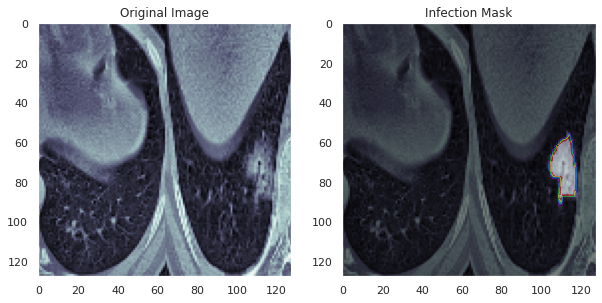

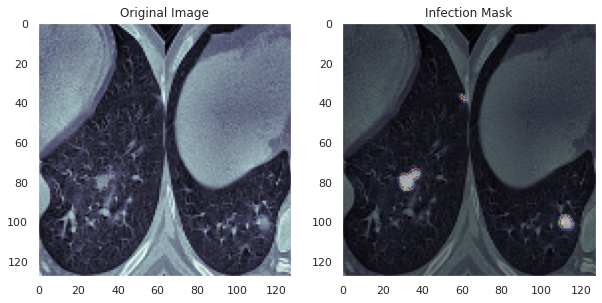

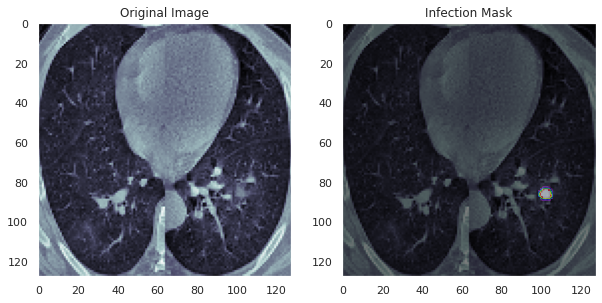

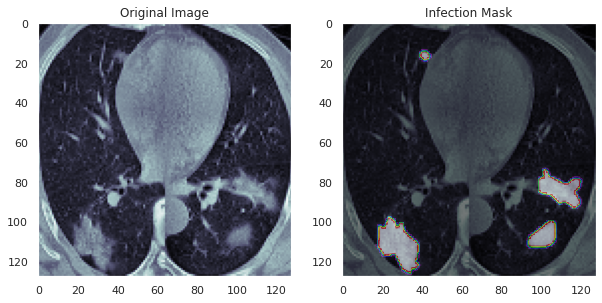

In [40]:
for index in [90,110,120,135,140,150,170,180]:
    plot_processed_sample([cts[index], infections[index]])

# Data Augmentation

In [41]:
sometimes = lambda aug: iaa.Sometimes(0.3, aug)
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of all images
    iaa.Flipud(0.2), # vertically flip 20% of all images
    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.80, 1.5)),
    iaa.LinearContrast((0.90, 1.5)),
    sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-30, 30), # rotate by -30 to +30 degrees
        ))
], random_order=True)

In [42]:
no_of_aug_imgs = 100
random_indices = np.random.randint(0, cts.shape[0], size=no_of_aug_imgs)
sample_cts = cts[random_indices]
sample_inf = infections[random_indices]

In [43]:
ctsa, infa = seq(images=sample_cts, 
                              segmentation_maps=sample_inf)
rcParams['figure.figsize'] = 60,60
rand = np.random.randint(0, no_of_aug_imgs, size=10)
print(type(rand), len(rand))

<class 'numpy.ndarray'> 10


In [44]:
rand

array([47, 76, 46, 32, 31, 65, 83, 52, 98, 69])

In [47]:
cells1 = [ctsa[i] for i in rand]
cells2 = [infa[i] for i in rand]

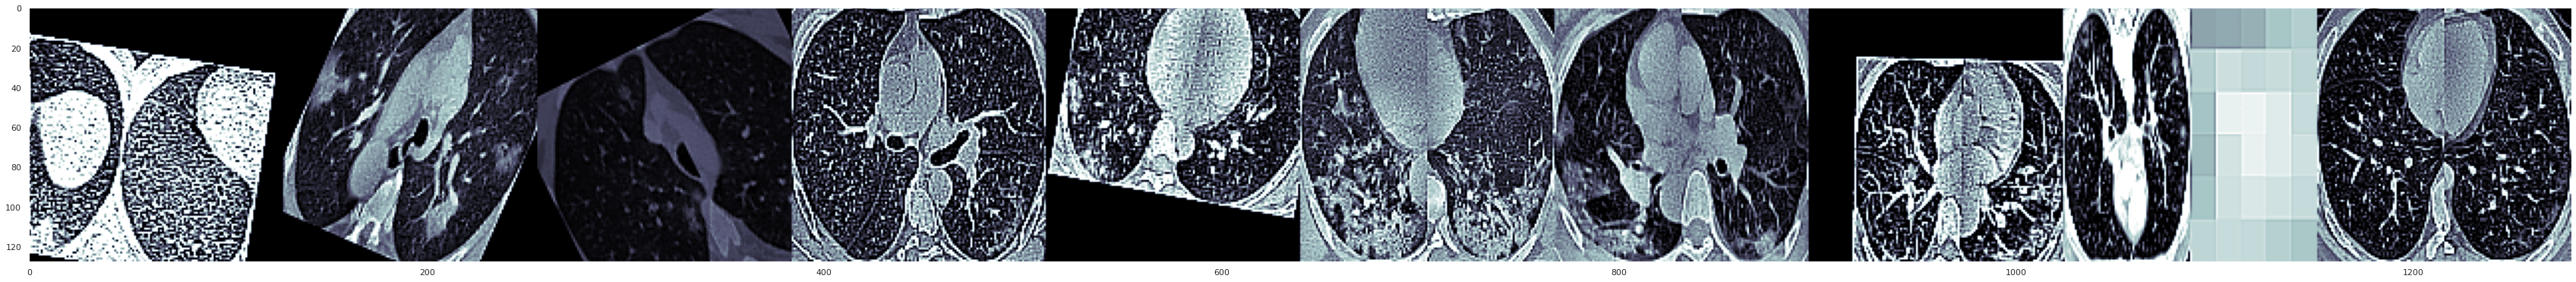

In [48]:
grid_image1 = np.hstack(cells1)
plt.grid(False)
plt.imshow(grid_image1, cmap = 'bone')

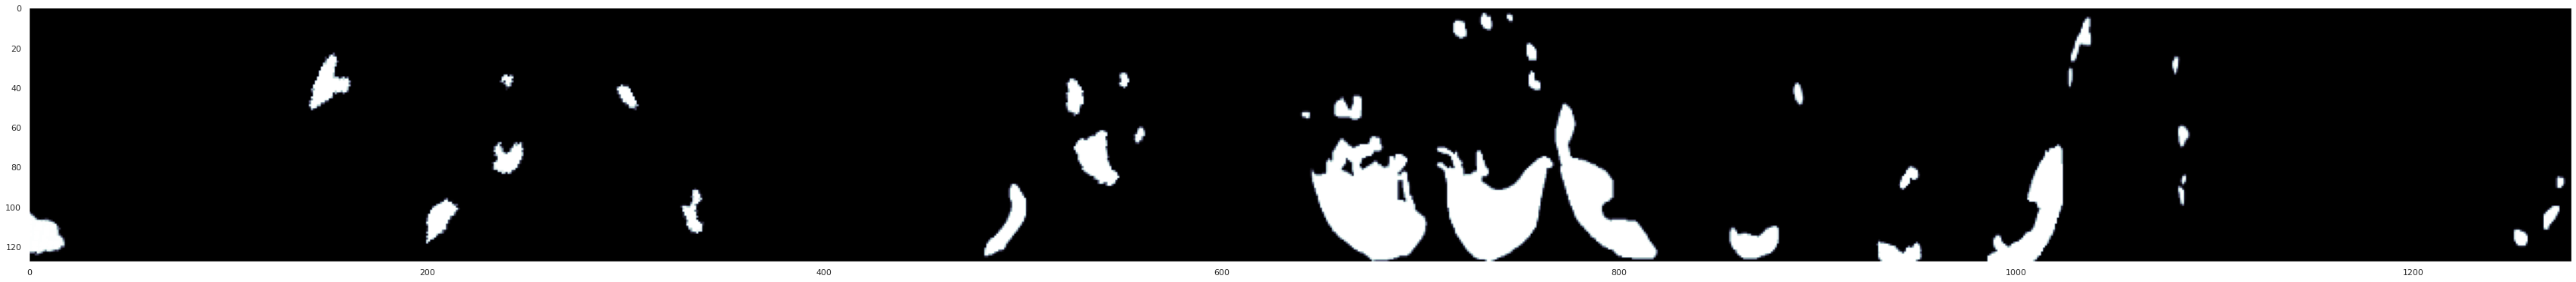

In [49]:
grid_image2 = np.hstack(cells2)
plt.grid(False)
plt.imshow(grid_image2, cmap = 'bone')

In [50]:
cts = np.concatenate((cts, ctsa), axis=0)
infections = np.concatenate((infections, infa), axis = 0)
# np.random.shuffle(cts)
# np.random.shuffle(infections)
print(cts.shape, infections.shape)

(1492, 128, 128) (1492, 128, 128)


In [51]:
cts=(cts-cts.min())/(cts.max()-cts.min())
infections=(infections-infections.min())/(infections.max()-infections.min())

In [52]:
cts = cts.reshape(len(cts), new_dim, new_dim, 1)
infections = infections.reshape(len(infections), new_dim, new_dim, 1)

In [53]:
joblib.dump(cts, 'cts_cropped_lungs_128.pkl')

['cts_cropped_lungs_128.pkl']

In [54]:
files.download('cts_cropped_lungs_128.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
joblib.dump(infections, 'infections_cropped_lungs_128.pkl')


['infections_cropped_lungs_128.pkl']

In [56]:
files.download('infections_cropped_lungs_128.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
cts=joblib.load('/content/drive/My Drive/cts_cropped_lungs_128.pkl')
infections=joblib.load('/content/drive/My Drive/infections_cropped_lungs_128.pkl')

In [58]:
x_train,x_valid,y_train,y_valid=train_test_split(cts,infections,train_size=0.7,random_state=42)

Loss functions and metrics

The Dice coefficient is very similar to the IoU. They are positively correlated, meaning if one says model A is better than model B at segmenting an image, then the other will say the same. Like the IoU, they both range from 0 to 1, with 1 signifying the greatest similarity between predicted and truth.

In [59]:
# Basically we use the smooth to avoid division by 0.
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_coeff(y_true, y_pred,smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = 0.5*binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    return loss

# UNET Model

In [60]:
inputs = Input((new_dim, new_dim, 1))

# contraction
c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (inputs)
c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)
p1 = Dropout(0.4)(p1)

c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p1)
c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)
p2 = Dropout(0.4)(p2)

c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p2)
c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)
p3 = Dropout(0.4)(p3)

c4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p3)
c4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
p4 = Dropout(0.4)(p4)
# ---------------------
c5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p4)
c5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c5)
# ---------------------
# Expansion
u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
u6 = BatchNormalization()(u6)
c6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u6)
c6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c6)


u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
u7 = BatchNormalization()(u7)
c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u7)
c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c7)


u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
u8 = BatchNormalization()(u8)
c8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u8)
c8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c8)


u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
u9 = BatchNormalization()(u9)
c9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u9)
c9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [61]:
batch_size = 32
epochs = 100
filepath_dice_coeff="unet_covid_weights_dice_coeff.hdf5"
filepath_loss = "unet_covid_weights_val_loss.hdf5"
checkpoint_dice = ModelCheckpoint(filepath_dice_coeff, monitor='val_dice_coeff', verbose=1, save_best_only=True, mode='max')
checkpoint_loss = ModelCheckpoint(filepath_loss, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [62]:
model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[dice_coeff])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [63]:
results = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(x_valid, y_valid),
                    callbacks = [checkpoint_dice, checkpoint_loss])

Epoch 1/100
33/33 [==============================] - 53s 522ms/step - loss: 0.5223 - dice_coeff: 0.2441 - val_loss: 3.5436 - val_dice_coeff: 2.2496e-04

Epoch 00001: val_dice_coeff improved from -inf to 0.00022, saving model to unet_covid_weights_dice_coeff.hdf5

Epoch 00001: val_loss improved from inf to 3.54364, saving model to unet_covid_weights_val_loss.hdf5
Epoch 2/100
33/33 [==============================] - 14s 417ms/step - loss: 0.3132 - dice_coeff: 0.5548 - val_loss: 1.4671 - val_dice_coeff: 3.4229e-04

Epoch 00002: val_dice_coeff improved from 0.00022 to 0.00034, saving model to unet_covid_weights_dice_coeff.hdf5

Epoch 00002: val_loss improved from 3.54364 to 1.46709, saving model to unet_covid_weights_val_loss.hdf5
Epoch 3/100
33/33 [==============================] - 14s 416ms/step - loss: 0.2498 - dice_coeff: 0.6475 - val_loss: 1.2054 - val_dice_coeff: 0.0016

Epoch 00003: val_dice_coeff improved from 0.00034 to 0.00160, saving model to unet_covid_weights_dice_coeff.hdf5



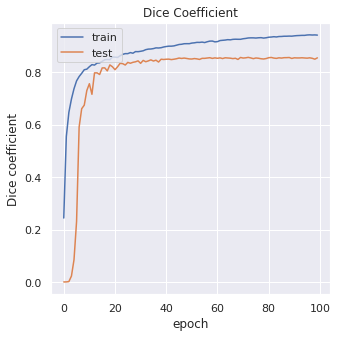

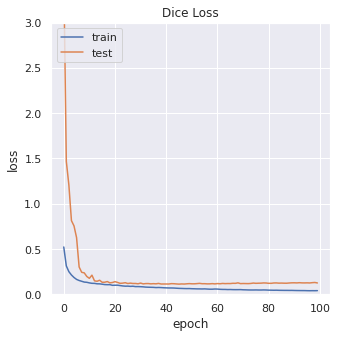

In [64]:
rcParams['figure.figsize'] = 5, 5
plt.plot(results.history['dice_coeff'])
plt.plot(results.history['val_dice_coeff'])
plt.title('Dice Coefficient')
plt.ylabel('Dice coefficient')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
# summarize history for loss
plt.ylim(0, 3)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Dice Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [65]:
plt.rcParams["axes.grid"] = False

# Generates output predictions for the input samples.

In [66]:
def compare_actual_and_predicted(image_no):
    temp = model.predict(cts[image_no].reshape(1,new_dim, new_dim, 1))

    fig = plt.figure(figsize=(15,15))

    plt.subplot(1,3,1)
    plt.imshow(cts[image_no].reshape(new_dim, new_dim),cmap='bone')
    plt.title('Original Image (CT)')

    plt.subplot(1,3,2)
    plt.imshow(infections[image_no].reshape(new_dim,new_dim))
    plt.title('Actual mask')

    plt.subplot(1,3,3)
    plt.imshow(temp.reshape(new_dim,new_dim))
    plt.title('Predicted mask')

    plt.show()

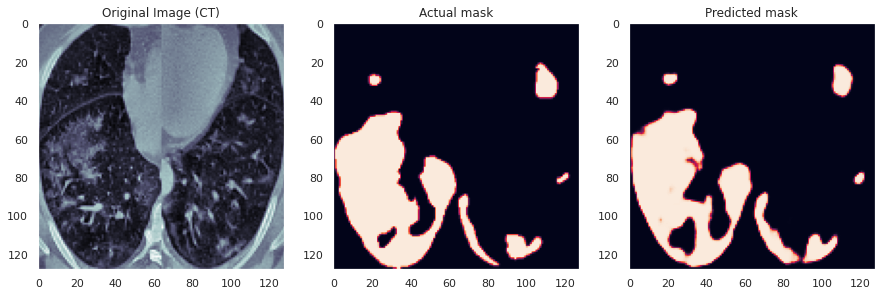

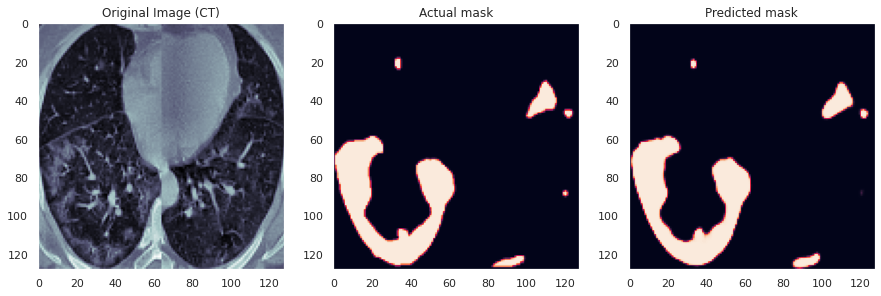

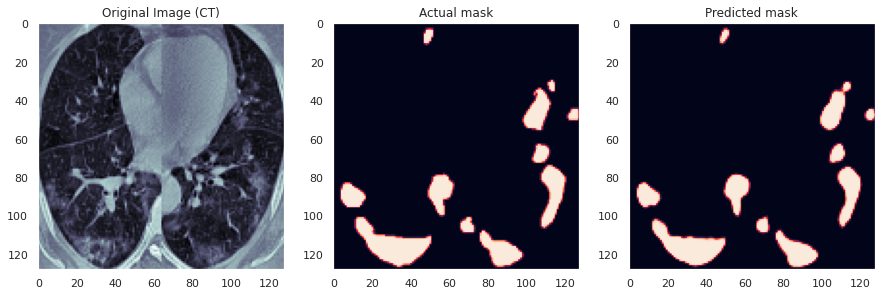

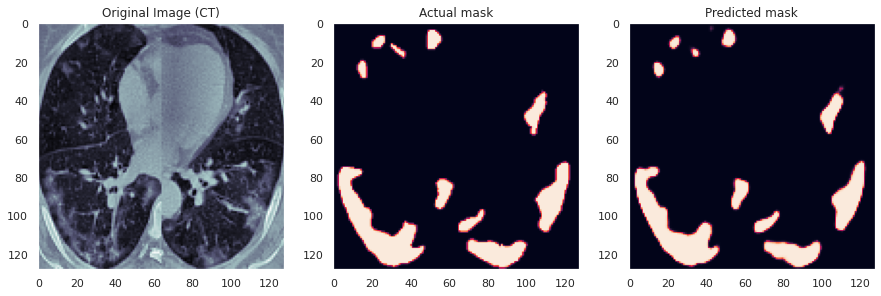

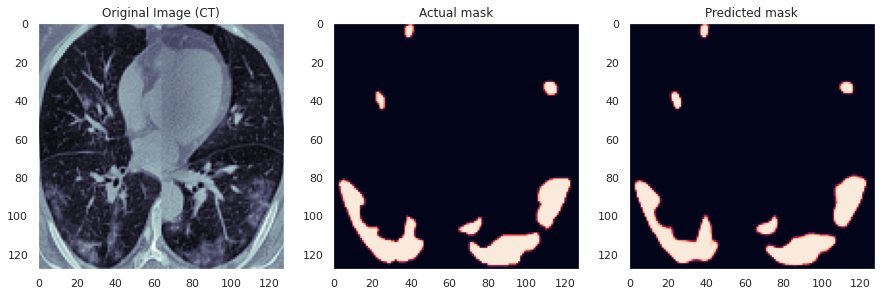

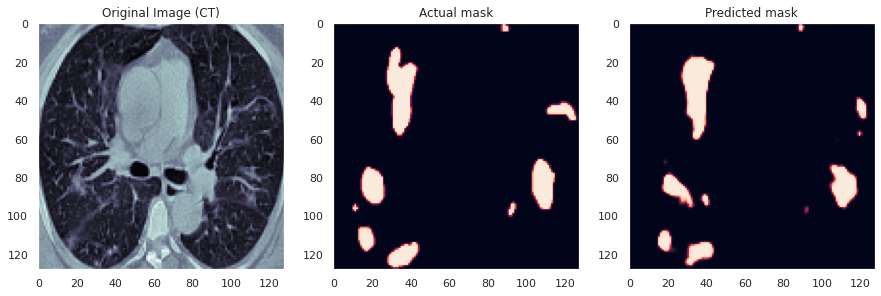

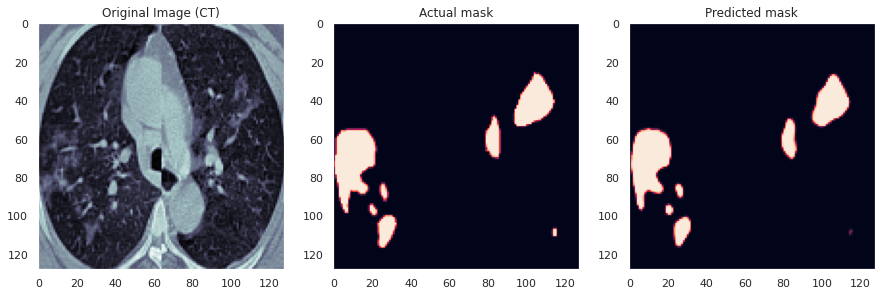

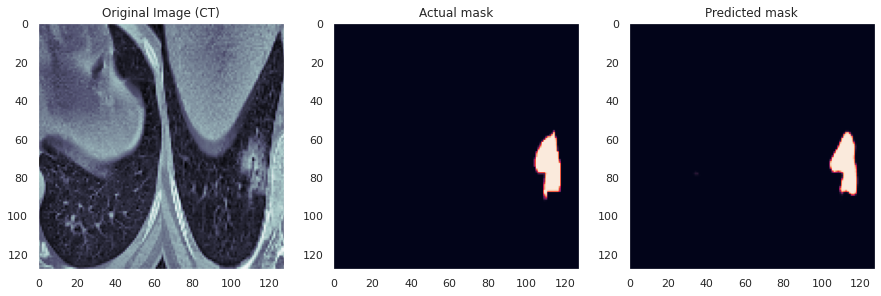

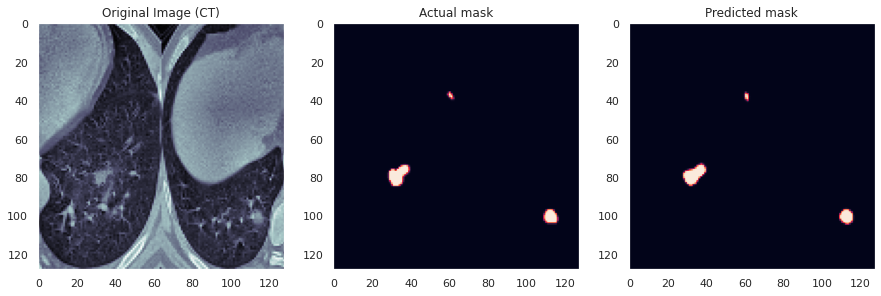

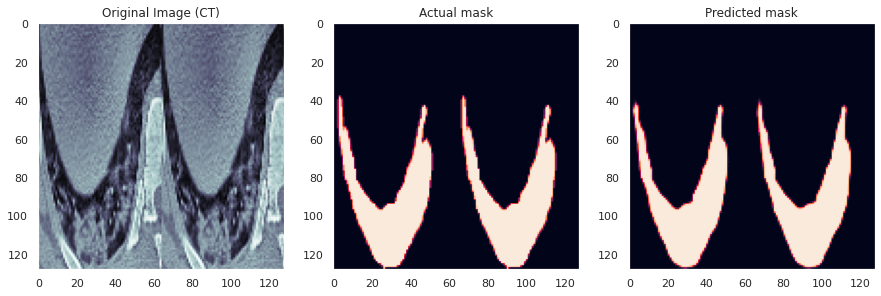

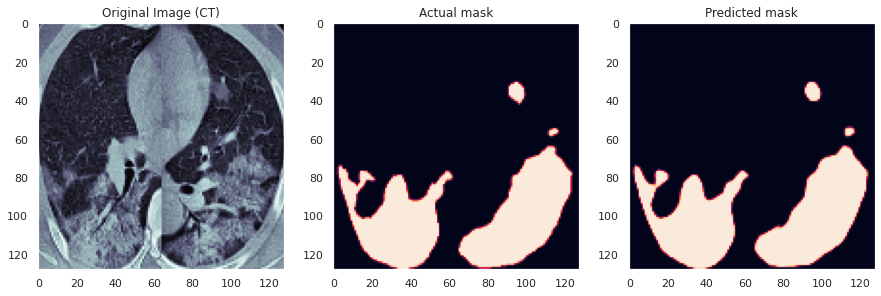

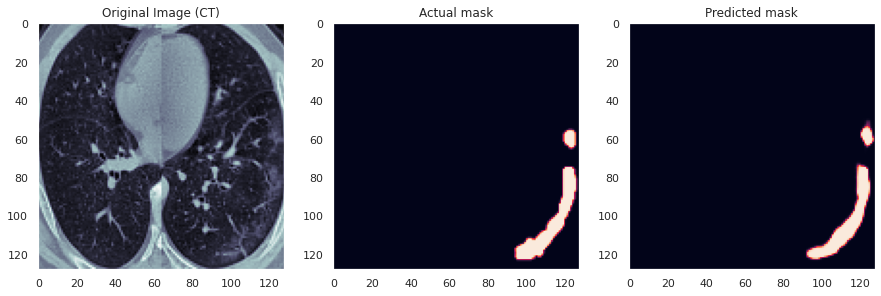

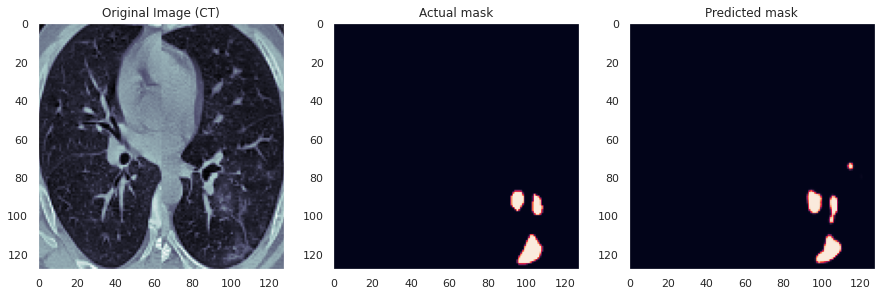

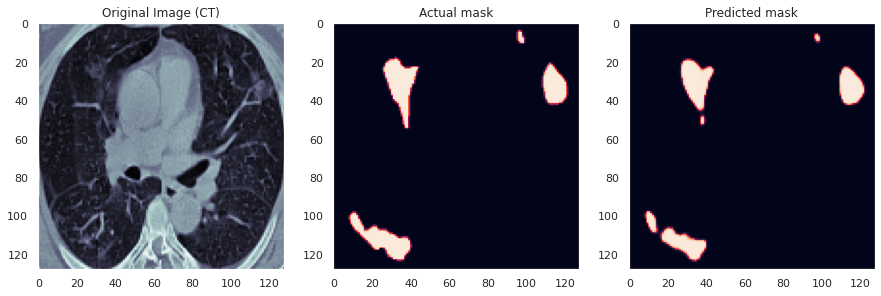

In [ ]:
for i in [30,40,50,55,60,100,120,140,150,250,300,355, 380, 90]:
    compare_actual_and_predicted(i)

In [67]:
score = model.evaluate(x_valid, y_valid, batch_size=32)
print("test loss, test dice coefficient:", score)
model.load_weights(filepath_dice_coeff)
model.save_weights('unet_0.85_inf_segm.h5')
files.download('unet_0.85_inf_segm.h5')
model_json = model.to_json()
with open("unet_0.85_inf_segm.json","w") as json_file:
     json_file.write(model_json)

files.download("unet_0.85_inf_segm.json")
score = model.evaluate(x_valid, y_valid, batch_size=32)
print("test loss, test dice coefficient:", score)

14/14 [==============================] - 2s 115ms/step - loss: 0.1253 - dice_coeff: 0.8553
test loss, test dice coefficient: [0.12534268200397491, 0.8552607893943787]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

14/14 [==============================] - 2s 112ms/step - loss: 0.1180 - dice_coeff: 0.8571
test loss, test dice coefficient: [0.1179773285984993, 0.8570989370346069]


In [68]:
# model.load_weights(filepath_dice_coeff)
model.load_weights('/content/drive/My Drive/unet_0.85_inf_segm.h5')
threshold_range = np.arange(0.10,0.85, 0.05)
print(threshold_range)
dices=[]
ious=[]
#Testing for different Threshold values
for t in threshold_range:
  iou=sm.metrics.IOUScore(threshold=t)   # Returns:	A callable iou_score instance. Can be used in model.compile(...) function.
  dice = sm.metrics.FScore(threshold=t)  # Returns: A callable f_score instance. Can be used in model.compile(...) function.
  model.compile(optimizer=Adam(lr=0.0005),loss=bce_dice_loss,metrics=[dice,iou])
  score=model.evaluate(x_valid,y_valid,batch_size=32)
  dices.append(score[1])
  ious.append(score[2])

[0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8 ]


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


14/14 [==============================] - 2s 111ms/step - loss: 0.1167 - f1-score: 0.8598 - iou_score: 0.7545


DICES: [0.8595498204231262, 0.8615051507949829, 0.8625306487083435, 0.8631369471549988, 0.8634465932846069, 0.8636244535446167, 0.8636907339096069, 0.8635042905807495, 0.863307535648346, 0.8630974888801575, 0.8628324866294861, 0.8623502850532532, 0.8617922067642212, 0.8609670996665955, 0.8598302006721497]
IOUS: [0.7539812326431274, 0.7570049166679382, 0.7585963010787964, 0.7595382928848267, 0.7600280046463013, 0.7603148221969604, 0.7604225277900696, 0.7601394653320312, 0.7598399519920349, 0.7595182061195374, 0.7591137290000916, 0.7583745718002319, 0.7575162053108215, 0.7562510371208191, 0.7545116543769836]
Best Threshold: 0.40000000000000013
Best dice score: 0.8636907339096069
Best iou score: 0.7604225277900696
Best Threshold: 0.40000000000000013


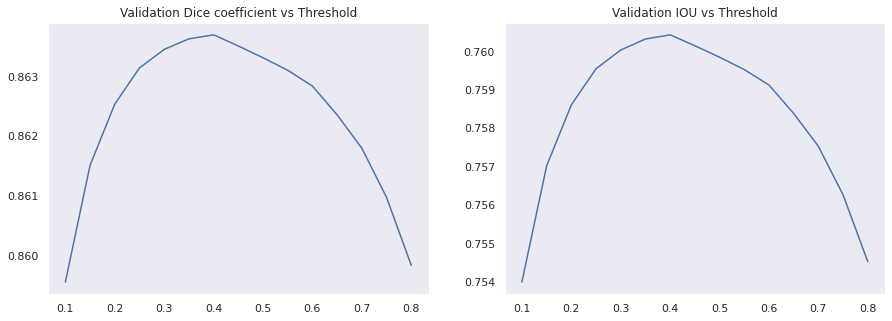

In [69]:
print('DICES:',dices)
print("IOUS:",ious)
print("Best Threshold:", threshold_range[np.argmax(dices)])
print("Best dice score:", dices[np.argmax(dices)])
print("Best iou score:", ious[np.argmax(ious)])
print("Best Threshold:", threshold_range[np.argmax(dices)])
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(threshold_range, dices)
plt.title("Validation Dice coefficient vs Threshold")

plt.subplot(1, 2, 2)
plt.plot(threshold_range, ious)
plt.title("Validation IOU vs Threshold")

plt.show()

In [70]:
the_new_range = np.arange(0.33,0.38, 0.001)
new_dices=[]
new_ious=[]

for t in the_new_range:
  iou = sm.metrics.IOUScore(threshold=t)
  dice = sm.metrics.FScore(threshold=t)
  model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[dice, iou])
  score = model.evaluate(x_valid, y_valid, batch_size=32)
  new_dices.append(score[1])
  new_ious.append(score[2])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


14/14 [==============================] - 2s 112ms/step - loss: 0.1167 - f1-score: 0.8637 - iou_score: 0.7604


In [71]:
print("New Best Threshold:", the_new_range[np.argmax(new_dices)])
print("Best new dice score:", new_dices[np.argmax(new_dices)])
print("Best new iou score:", new_ious[np.argmax(new_ious)])

New Best Threshold: 0.37300000000000005
Best new dice score: 0.8637003302574158
Best new iou score: 0.7604328989982605


Best Threshold: 0.37300000000000005


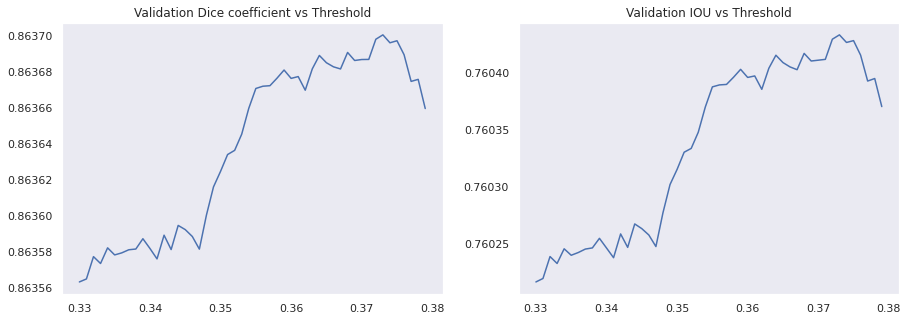

In [72]:
print("Best Threshold:", the_new_range[np.argmax(new_dices)])
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(the_new_range, new_dices)
plt.title("Validation Dice coefficient vs Threshold")

plt.subplot(1, 2, 2)
plt.plot(the_new_range, new_ious)
plt.title("Validation IOU vs Threshold")

plt.show()
the_prec_rec_range = np.arange(0,1, 0.05)

In [73]:
precisions=[]
recalls=[]
new_dices=[]

for t in the_prec_rec_range:
  precision = sm.metrics.Precision(threshold=t)
  recall = sm.metrics.Recall(threshold=t)
  dice = sm.metrics.FScore(threshold=t)
  model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[precision, recall,dice])
  score = model.evaluate(x_valid, y_valid, batch_size=32)
  precisions.append(score[1])
  recalls.append(score[2])
  new_dices.append(score[3])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


14/14 [==============================] - 2s 112ms/step - loss: 0.1167 - precision: 0.9169 - recall: 0.7889 - f1-score: 0.8478


In [74]:
print("Best Threshold for dice:", the_prec_rec_range[np.argmax(new_dices)])
print("Best precision score:", precisions[np.argmax(new_dices)])
print("Best recall score:", recalls[np.argmax(new_dices)])
print("Best new dice score:", new_dices[np.argmax(new_dices)])

Best Threshold for dice: 0.4
Best precision score: 0.8615311980247498
Best recall score: 0.8662089109420776
Best new dice score: 0.8636907339096069


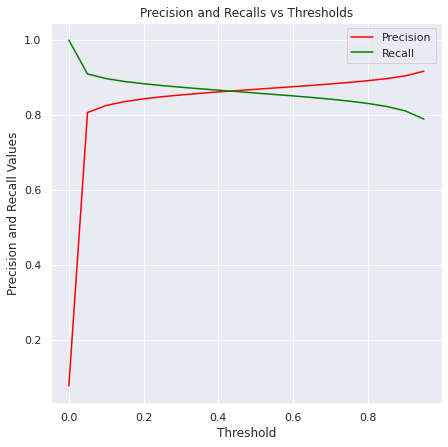

In [75]:
rcParams['figure.figsize'] = 7,7
plt.rcParams["axes.grid"] = True
plt.title("Precision and Recalls vs Thresholds")
plt.xlabel('Threshold')
plt.ylabel('Precision and Recall Values')
plt.plot(the_prec_rec_range,precisions, color='red')
plt.plot(the_prec_rec_range, recalls, color='green')
plt.legend(['Precision', 'Recall'])